# YOLO-KP SDNN Example

This tutorial demonstrates the inference of YOLO-KP SDNN (training example scripts [here](https://github.com/lava-nc/lava-dl/tree/main/tutorials/lava/lib/dl/slayer/tiny_yolo_sdnn)) on both CPU and Loihi 2 neurocore.

![image](https://github.com/lava-nc/lava/assets/29907126/61057e64-71b3-4ab8-a7ea-39d0cdbac70d)

YOLO-KP is a fully convolutional single-headed variant of TinyYOLOv3 object detection architecture specifically designed for 8 chip Loihi 2 form factor called Kapoho Point (KP). The inference example uses the following lava components

1. __Network on Loihi 2:__ YOLO-KP network generated from its NetX description. It is a hierarchical network consisting of all the layers of YOLO-KP. This is the portion that runs on Loihi.
2. __Data sparsification on SuperHost:__ Delta encoder process that performs frame difference to sparsify the input being communicated to the YOLO-KP network. This process runs on Python.
3. __Data communication in and out of lava processes:__ `Injector` process to send raw input to the lava network and `Extractor` process to receive raw output of YOLO-KP. These processes run on Python.
4. __Data relay in and out of Loihi chip:__ Input and output adapter process which relay the communication into the chip and out of the chip. Since YOLO-KP is fully convolutional, the adapters translate to/from python spike and Loihi convolution spike.

> ℹ️ This example currently does not make use of high speed IO capabilities of Loihi and hence the execution is slow. Once the software support is enabled in Lava, these adapters will not be required and shall be removed.

In [1]:
import os
import yaml
import logging

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.proc import embedded_io as eio
from lava.proc import io
from lava.proc.cyclic_buffer.process import CyclicBuffer

from lava.lib.dl import netx
from lava.lib.dl import slayer
from lava.lib.dl.slayer import obd

from utils import DataGenerator, YOLOPredictor, nms, YOLOMonitor, DeltaEncoder
from IPython.display import display, clear_output

         Only Prophesee DVS demo will not run properly.
         Please install it from https://github.com/prophesee-ai/prophesee-automotive-dataset-toolbox


# Import modules for Loihi2 execution

Check if Loihi2 compiler is available and import related modules.

In [2]:
loihi2_is_available = True
random_seq = False

if loihi2_is_available:
    # os.environ["SLURM"] = "1"
    # # os.environ["LOIHI_GEN"] = "N3C1"
    # os.environ["PARTITION"] = "kp_inf"
    # os.environ["BOARD"] = "ncl-og-01"
    # # os.environ["NXOPTIONS"] = "--pio-cfg-chip=0x41FF"

    os.environ["LOIHI_GEN"] = "N3C1"
    os.environ["NXSDKHOST"] = "ncl-gdc-vpx-01.zpn.intel.com"  # this needs to be changed for user specific system
    os.environ["NXOPTIONS"] = "--pio-cfg-chip=0x4191"         # this is board specific, most relaxed config is 0x41FF
    
    from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions, CompilerLogs
    CompilerOptions.verbose = True
    CompilerOptions.show_resource_count = True
    CompilerOptions.log_resource_count = True
    # CompilerOptions.large_mpds_max_size = (1 << 14) - 10000  # 2000 dwords for spike buffer
    compression = io.encoder.Compression.DELTA_SPARSE_8
else:
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")
    compression = io.encoder.Compression.DENSE

ImportError: cannot import name 'CompilerLogs' from 'lava.magma.compiler.subcompilers.nc.ncproc_compiler' (/homes/mbrehove/mylava/lava_loihi-0.7.0/src/lava/magma/compiler/subcompilers/nc/ncproc_compiler.py)

## Set execution parameters

The network execution parameters can be divided into three categories:

1. __Model parameters:__ these are parameters of the YOLO model used for the training and shall be reused to replicate the same behavior during inference.
2. __Inference parametrs:__ these are parameters just for the inference.
3. __Data processing parameters:__ these are parameters need to perform _pre_ and _post_ processing before the input and on the output of the network respectively.

In [3]:
# Model arguments
trained_folder = os.path.abspath('../../slayer/tiny_yolo_sdnn/Trained_yolo_kp')
with open(trained_folder + '/args.txt', 'rt') as f:
    model_args = slayer.utils.dotdict(yaml.safe_load(f))

# Additional inference arguments
inference_args = slayer.utils.dotdict(loihi=loihi2_is_available,
                                      spike_exp=4,    # This sets the decimal/fraction precision of spike message to 4 bits
                                      num_steps=100)  # Number of frames to perform inference on

# Pre and post processing parameters
pre_args = slayer.utils.dotdict(input_mean=np.array([0.485, 0.456, 0.406]),  # Input normalization mean
                                input_std=np.array([0.229, 0.224, 0.225]))   #                     & std
post_args = slayer.utils.dotdict(anchors=np.array([(0.28, 0.22),  # YOLO head's anchor preset scales
                                                   (0.38, 0.48),
                                                   (0.90, 0.78)]))

## Load YOLO-KP network

Loading the network is a simple NetX call on the trained model computational graph. It will generate an hierarchical lava process representing the entire YOLO-KP network.

In [4]:
net = netx.hdf5.Network(trained_folder + '/network.net',
                        skip_layers=1,  # First layer does delta encoding. We will only send it's sparsified output
                        input_message_bits=16,  # This means the network takes 16bit graded spike input
                        # num_layers=2,
                        spike_exp=inference_args.spike_exp)
print(f'The model was trained for {model_args.dataset} dataset')
print(f'\nNetwork Architecture ({model_args.model}):'); print('=' * (24 + len(model_args.model))); print(net)

The model was trained for BDD100K dataset

Network Architecture (yolo_kp):
|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Conv      |  224|  224|   16| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |  112|  112|   32| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   56|   56|   64| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   28|   28|  128| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   28|   28|  256| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  256| 3, 3| 2, 2| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  512| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|  256| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |   14|   14|  512| 3, 3| 1, 1| 1, 1| 1, 1|    1|False|
|Conv      |   14|   14|   48| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|


## Dataset and input source

The dataset is the same module that is used for training. It is wrapped around by a data generator module that will generate an individual frame and its annotation at every time-step. The data generator also takes care of data normalization using the mean and variance supplied.

In [5]:
randomize_seq = random_seq
start_idx = np.random.randint(len(test_set)) if random_seq else 0
test_set = obd.dataset.BDD(root=model_args.path, dataset='track',
                           train=False, randomize_seq=randomize_seq,
                           seq_len=inference_args.num_steps)
# test_set.datasets[0].ids[0] = 'b20b69d2-6e2b9e73'
data_gen = DataGenerator(dataset=test_set, start_idx=start_idx,
                         mean=pre_args.input_mean, std=pre_args.input_std)

## Input preprocessing and encoding

The input preprocessing involves quantization of the numeric data making it ready to be processed on the chip. A fractional representation of 6 bits was used in the weight of the network during training (`weight_exp`) which is also accounted for during quantization.

The quantized input frames are then processed the the lava processes `sender`, `encoder` (and `inp_adapter` for Loihi execution) which will be connected in a sequential manner below.

In [6]:
quantize = netx.modules.Quantize(exp=6)  # convert to fixed point representation with 6 bit of fraction
sender = io.injector.Injector(shape=net.inp.shape, buffer_size=128)
# encoder = io.encoder.DeltaEncoder(shape=net.inp.shape,
#                                   vth=net.net_config['layer'][0]['neuron']['vThMant'],
#                                   spike_exp=0 if inference_args.loihi else net.spike_exp,
#                                   num_bits=8,
#                                   compression=compression)
encoder = DeltaEncoder(vth=net.net_config['layer'][0]['neuron']['vThMant'],
                       spike_exp=0,
                       num_bits=8)
# if inference_args.loihi:
#     # This is needed for the time being until high speed IO is enabled
#     inp_adapter = eio.spike.PyToN3ConvAdapter(shape=encoder.s_out.shape,
#                                               num_message_bits=16,
#                                               spike_exp=net.spike_exp,
#                                               compression=compression)

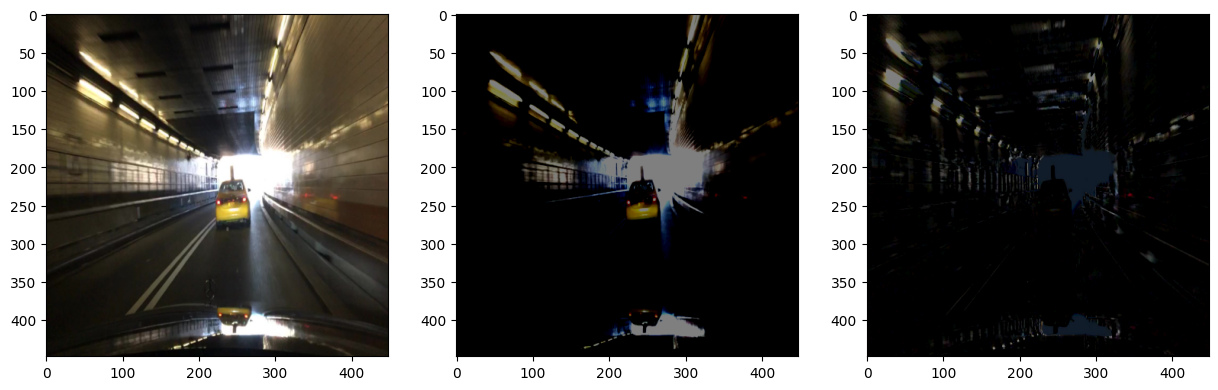

In [7]:
frames = []
annotations = []
raw_frames = []
for t in range(99):
    frame, annotation, raw_frame = data_gen()
    frame = quantize(frame)
    frame = encoder(frame)
    # if t % 32 != 0:
    #     frame *= 0
    frames.append(frame)
    annotations.append(annotation)
    raw_frames.append(raw_frame)
    clear_output(wait=True)
    # display(frame)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(raw_frames[0].permute([1, 2, 0]))
ax[1].imshow(frames[0].transpose([1, 0, 2]))
ax[2].imshow(frames[1].transpose([1, 0, 2]))

In [8]:
input_source = CyclicBuffer(first_frame=frames[0],
                            replay_frames=np.array(frames[1:]).transpose([1, 2, 3, 0]),
                            spike_exp=net.spike_exp)

## Output decoding and post processing

The output of YOLO-KP goes through (`state_adapter` for Loihi execution), `receiver` and `dequantizer` lava processes which will be connected sequentially. The raw outputs needs to be processed using `yolo_predictor` which transforms the input to the actual bounding box predictions of the network.

In [9]:
# if inference_args.loihi:
#     # This is needed for the time being until high speed IO is enabled
#     state_adapter = eio.state.ReadConv(shape=net.out.shape)
# receiver = io.extractor.Extractor(shape=net.out.shape, buffer_size=128)
# dequantize = netx.modules.Dequantize(exp=net.spike_exp + 12, num_raw_bits=24)
# yolo_predictor = YOLOPredictor(anchors=post_args.anchors, clamp_max=model_args.clamp_max)

## Output visualization

`YOLOMonitor` is a flexible output visualization and evaluation module. It continuously evaluates the mAP score of the output predictions. It can also be passed a callable function that can be used to display. In this case it is a basic iPython display routine.

In [10]:
# def output_visualizer(annotated_frame, map_score, frame_idx):
#     clear_output(wait=True)
#     display(annotated_frame)
#     print(f'Processed frame {frame_idx}')
#     print(f'Object detection mAP@0.5 = {map_score:.2f}')
    
# yolo_monitor = YOLOMonitor(viz_fx=output_visualizer, class_list=test_set.classes)

## Data buffers / delays

There is a latency in the prediction equal to the number of layers the network has and the encoding step. Two FIFO buffers are used to synchronize the input frame and target annotation with the predicted output.

In [11]:
# frame_buffer = netx.modules.FIFO(depth=len(net) + 1)
# annotation_buffer = netx.modules.FIFO(depth=len(net) + 1)

# Connect Lava processes

In [12]:
# if inference_args.loihi:
#     sender.out_port.connect(encoder.a_in)
#     encoder.s_out.connect(inp_adapter.inp)
#     inp_adapter.out.connect(net.inp)
#     state_adapter.connect_var(net.out_layer.neuron.sigma)
#     state_adapter.out.connect(receiver.in_port)
# else:
#     sender.out_port.connect(encoder.a_in)
#     encoder.s_out.connect(net.inp)
#     net.out.connect(receiver.in_port)
input_source.s_out.connect(net.inp)

In [13]:
num_steps = inference_args.num_steps
# num_steps = 10000

In [14]:
from lava.utils import loihi2_profiler
power_logger = loihi2_profiler.Loihi2Power(num_steps=num_steps)
runtime_logger = loihi2_profiler.Loihi2ExecutionTime()
memory_logger = loihi2_profiler.Loihi2Memory()
activity_logger = loihi2_profiler.Loihi2Activity()
spike_logger = loihi2_profiler.Loihi2Spike()

callback_fxs=[power_logger, runtime_logger,
              memory_logger,
              activity_logger,
              spike_logger,
             ]

## Pre-execution static power measurement

In [15]:
from nxcore.arch.n3b.n3board import N3Board

pre_num_steps = 100000
static_power_logger = loihi2_profiler.Loihi2Power(num_steps=pre_num_steps)

if "BOARD" in os.environ.keys() or "NXSDKHOST" in os.environ.keys():
    board = N3Board(1, 0)
    static_power_logger.pre_run_callback(board, {})
    board.run(pre_num_steps)
    static_power_logger.post_run_callback(board, {})
    board.disconnect()
else:
    raise RuntimeError('Consistent board is not being targetted. The static measurement may happen on different board. Consider setting BOARD or NXSDKHOST environment.')

INFO:DRV:  Running in non-slurm environment on : ncl-gdc-vpx-01.zpn.intel.com


/home/sshresth/lava-vpx/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


INFO:HST:  Initializing PAC193X registers to defaults.
INFO:DRV:  Connecting to ncl-gdc-vpx-01.zpn.intel.com:42151
INFO:DRV:      Host server up..............Done 4.32s
INFO:DRV:      Mapping chipIds.............Done 0.02ms
INFO:DRV:      Mapping coreIds.............Done 0.01ms
INFO:DRV:      Partitioning neuron groups..Done 0.00ms
INFO:DRV:      Mapping axons...............Done 0.03ms
INFO:DRV:      Writes SpikeIO Config to FileDone 0.01ms
INFO:DRV:      Partitioning MPDS...........Done 0.19ms
INFO:DRV:      Compiling Embedded snips....Done 0.47s
INFO:DRV:      Compiling Host snips........Done 0.61s
INFO:DRV:      Compiling Register Probes...Done 0.07ms
INFO:DRV:      Compiling Spike Probes......Done 0.01ms
INFO:HST:  Args chip=0 cpu=0 /home/sshresth/lava-vpx/frameworks.ai.nx.nxsdk/nxcore/arch/base/pre_execution/../../../../temp/6490adc4-d046-11ee-ae1b-43ad9ec7bf4f/launcher_chip0_cpu0.bin --chips=1 --remote-relay=0 
INFO:HST:  Args chip=0 cpu=1 /home/sshresth/lava-vpx/frameworks.ai.nx

# Setup execution

The network is run in _non-blocking mode_. Note the `blocking=False` argument below. In non-blocking mode we can start running the lava process and do other computations in parallel. Here we will preprocess the data, send it to lava network using `sender` (`lava.proc.io.injector.Injector` instance), receive data from lava using `receiver` (`lava.proc.io.extractor.Extractor` instance), and perform additional processing, while the Lava network is running in parallel.

In [16]:
# run_condition = RunSteps(num_steps=num_steps, blocking=False)
run_condition = RunSteps(num_steps=num_steps)

if inference_args.loihi:
    exception_proc_model_map = {io.encoder.DeltaEncoder: io.encoder.PyDeltaEncoderModelSparse}
    run_config = Loihi2HwCfg(exception_proc_model_map=exception_proc_model_map,
                             callback_fxs=callback_fxs)
# else:
#     exception_proc_model_map = {io.encoder.DeltaEncoder: io.encoder.PyDeltaEncoderModelDense}
#     run_config = Loihi2SimCfg(select_tag='fixed_pt',
#                               exception_proc_model_map=exception_proc_model_map)

# Run YOLO-KP inference

The following will compile and run the Lava network.

> ℹ️ The network is large. It will take a while for the compilation to finish.

In [17]:
# sender._log_config.level = logging.INFO
# sender.run(condition=run_condition, run_cfg=run_config)

In [18]:
# for t in range(num_steps):
#     frame, annotation, raw_frame = data_gen()
#     frame = quantize(frame)
    
#     sender.send(frame)        # This sends the input frame to the Lava network
#     out = receiver.receive()  # This receives the output from the Lava network
#     raw_out = out
    
#     out = dequantize(out)
#     input_frame = frame_buffer(raw_frame)
#     gt_ann = annotation_buffer(annotation)
#     if input_frame is not None:  # valid output from FIFO buffer
#         predictions = yolo_predictor(out)
#         pred_bbox = nms(predictions)
#         gt_bbox = obd.bbox.utils.tensor_from_annotation(gt_ann).cpu().data.numpy()
#         yolo_monitor(input_frame, gt_bbox, pred_bbox)
#     else:
#         print(f'Frame {t} queued in pipeline.', end='\r')

# sender.wait()
# sender.stop()

In [19]:
net._log_config.level = logging.INFO
net.run(condition=run_condition, run_cfg=run_config)
net.wait()
net.stop()

2024-02-20 15:18:47.869868, Generating Nets
2024-02-20 15:18:47.869954, Creating Process Models
2024-02-20 15:18:47.870458, Creating Nets
2024-02-20 15:18:51.735272, Creating NPG
2024-02-20 15:18:51.736079, Creating RegNets
2024-02-20 15:20:08.209588, NcProc Init done
2024-02-20 15:20:12.509747, Starting Partiton
2024-02-20 15:20:14.064681, Done iteration 0
2024-02-20 15:20:16.260997, Done iteration 1
2024-02-20 15:20:18.450475, Done iteration 2
Partitioning converged after iteration=3
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|       2|       2|    2688|    3072|    2688|       0|    8452|       4|Conv(4, 14, 48)
|       1|       1|    3584|   13824|      56|      28|   17494|      32|Conv(8, 7, 64)
|       1|       1|    3584|   10752|      14|      56|   14408|      14|Conv(2, 7, 256)

/home/sshresth/lava-vpx/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


INFO:DRV:  Running in non-slurm environment on : ncl-gdc-vpx-01.zpn.intel.com
INFO:HST:  Initializing PAC193X registers to defaults.
INFO:DRV:  Connecting to ncl-gdc-vpx-01.zpn.intel.com:33571
INFO:DRV:      Host server up..............Done 4.57s
INFO:DRV:      Mapping chipIds.............Done 0.02ms
INFO:DRV:      Mapping coreIds.............Done 4.40ms
INFO:DRV:      Partitioning neuron groups..Done 0.25s
INFO:DRV:      Mapping axons...............Done 1.25s
INFO:DRV:      Configuring Spike Block.....Done 0.00ms
INFO:DRV:      Writes SpikeIO Config to FileDone 0.02ms
INFO:DRV:      Initializes Python MQ.......Done 0.00ms
INFO:DRV:      Partitioning MPDS...........Done 0.15s
INFO:DRV:      Compiling Embedded snips....Done 1.49s
INFO:DRV:      Compiling Host snips........Done 0.88s
INFO:DRV:      Compiling Register Probes...Done 0.07ms
INFO:DRV:      Compiling Spike Probes......Done 0.02ms
INFO:HST:  Args chip=0 cpu=0 /home/sshresth/lava-vpx/frameworks.ai.nx.nxsdk/nxcore/arch/base/pre_

## Execution Time Results

Execution time profiler provies a time series of `time_per_step` and an average `avg_time_per_step`.

In [20]:
# runtime measurements
inference_rate = 1e6 / runtime_logger.avg_time_per_step
total_inference_time = num_steps * runtime_logger.avg_time_per_step * 1e-6
time_per_step = runtime_logger.avg_time_per_step
latency = runtime_logger.avg_time_per_step * len(net)

print(f'Time per timestep : {time_per_step:10.2f} us')
print(f'Latency           : {latency:10.2f} us')
print(f'Throughput        : {inference_rate:10.2f} fps')

Time per timestep :    8960.82 us
Latency           :   89608.18 us
Throughput        :     111.60 fps


## Power Results

The power profiler measures the power used by the Loihi system. It provies the individual measurements used by the 
* Loihi 2 neurocore circuits (`vdd_power`)
* Loihi 2 memory circuits (`vddm_power`)
* Loihi 2 input-output pheripherial circuits (`vddio_power`)

along with the total power (`total_power`). It also measures the static power of system when the system is idle.

In [21]:
# power measurements
vdd_p = power_logger.vdd_power  # neurocore power
vddm_p = power_logger.vddm_power  # memory power
vddio_p = power_logger.vddio_power  # IO power
total_power = power_logger.total_power

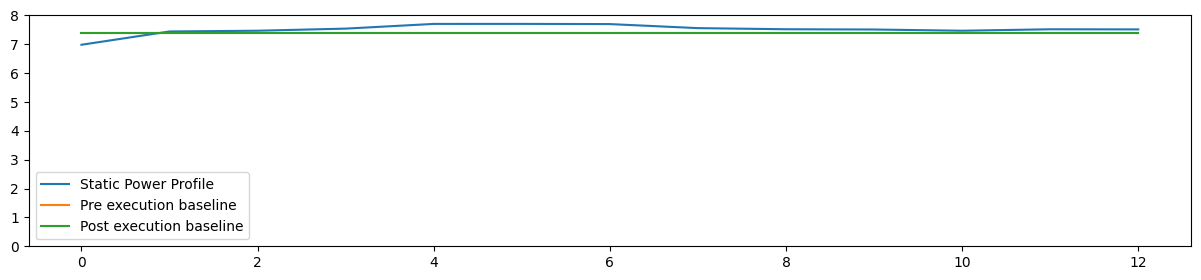

In [22]:
plt.figure(figsize=(15, 3))
plt.plot(static_power_logger.total_power, label='Static Power Profile')
plt.plot(static_power_logger.static_total_power * np.ones_like(static_power_logger.total_power), label='Pre execution baseline')
plt.plot(power_logger.static_total_power * np.ones_like(static_power_logger.total_power), label='Post execution baseline')
plt.ylim(0, 8)
plt.legend()

In [23]:
num_chips = 16
if 'PARTITION' in os.environ.keys():
    if 'kp' in os.environ['PARTITION']:
        num_chips = 8

In [24]:
active_chips = (max(activity_logger.core_idx + 120 * activity_logger.chip_idx) + 119) // 120

# per chip static power
static_total_power_per_chip = static_power_logger.static_total_power / num_chips
static_vdd_p_per_chip = static_power_logger.static_vdd_power / num_chips
static_vddm_p_per_chip = static_power_logger.static_vddm_power / num_chips
static_vddio_p_per_chip = static_power_logger.static_vddio_power / num_chips

# compensate for static power of unused chips
total_power -= (num_chips - active_chips) * static_total_power_per_chip
vdd_p -= (num_chips - active_chips) * static_vdd_p_per_chip
vddm_p -= (num_chips - active_chips) * static_vddm_p_per_chip
vddio_p -= (num_chips - active_chips) * static_vddio_p_per_chip

# active chips static power
static_total_power = power_logger.static_total_power - (num_chips - active_chips) * static_total_power_per_chip
static_vdd_p = power_logger.static_vdd_power - (num_chips - active_chips) * static_vdd_p_per_chip
static_vddm_p = power_logger.static_vddm_power - (num_chips - active_chips) * static_vddm_p_per_chip
static_vddio_p = power_logger.static_vddio_power - (num_chips - active_chips) * static_vddio_p_per_chip

In [25]:
total_power_mean = np.mean(total_power)
vdd_p_mean = np.mean(vdd_p)
vddm_p_mean = np.mean(vddm_p)
vddio_p_mean = np.mean(vddio_p)
dynamic_power_mean = total_power_mean - static_total_power

print(f'Total Power   : {total_power_mean:.6f} W')
print(f'Dynamic Power : {dynamic_power_mean:.6f} W')
print(f'Static Power  : {static_total_power:.6f} W')
print(f'VDD Power     : {vdd_p_mean:.6f} W')
print(f'VDD-M Power   : {vddm_p_mean:.6f} W')
print(f'VDD-IO Power  : {vddio_p_mean:.6f} W')

Total Power   : 4.669575 W
Dynamic Power : 0.513931 W
Static Power  : 4.155645 W
VDD Power     : 2.141836 W
VDD-M Power   : 2.322751 W
VDD-IO Power  : 0.204989 W


In [26]:
total_energy = total_power_mean / inference_rate
dynamic_energy = (total_power_mean - static_total_power) / inference_rate
print(f'Total Energy per inference   : {total_energy * 1e3:.6f} mJ')
print(f'Dynamic Energy per inference : {dynamic_energy * 1e3:.6f} mJ')

Total Energy per inference   : 41.843216 mJ
Dynamic Energy per inference : 4.605241 mJ


## Activity Results

The activity profiler measures the Loihi 2 neurocore activity metrics such as synaptic operations (`syn_ops`), neuron_updates (`dendrite_updates`), input spikes (`spikes_in`), output spikes (`axon_out`). and more.

The activity metrics provide information about the bottlenecks in each cores and provide intution on where the netowrk and it's mapping can be improved.

In [27]:
import itertools
ucode_passes = 2 # 2 passes for sdn_relu
# ann_macs = np.array([4816896 / 4] * 4  # YOLO-KP:BDD100K distributed over core placement
#                     + [231211008 / 32] * 32
#                     + [25690112 / 14] * 14
#                     + [231211008 / 32] * 32
#                     + [115605504 / 16] * 16
#                     + [231211008 / 56] * 56
#                     + [57802752 / 28] * 28
#                     + [57802752 / 56] * 56
#                     + [57802752 / 112] * 112
#                     + [21676032 / 224] * 224)
num_cores_per_layer = CompilerLogs.partition_distr[:, 7]
macs_per_layer = [4816896, 231211008, 25690112, 231211008, 115605504,
                  231211008, 57802752, 57802752, 57802752, 21676032]
ann_macs = np.array(list(itertools.chain.from_iterable([[m / n] * n
                                                        for (m, n) in zip(macs_per_layer,
                                                                          num_cores_per_layer)])))
synops_per_frame = np.sum(activity_logger.syn_ops / num_steps)
ann_ops_per_frame = np.sum(ann_macs)
synops_sparsity_factor = ann_ops_per_frame / synops_per_frame

num_valid = len(ann_macs)
activity_sparsity_factor = activity_logger.dendrite_updates[4:].sum() / activity_logger.spike_axon_in[4:].sum() / ucode_passes
activity_sparsity = np.ones(activity_logger.dendrite_updates.shape)
activity_sparsity[:num_valid] = activity_logger.dendrite_updates[:num_valid] / activity_logger.spike_axon_in[:num_valid] / ucode_passes
activity_sparsity[:4] = 1  # first 4 cores are output cores that only contain sigma neurons

tops = synops_per_frame * inference_rate / 1e12
tops_watt = tops / total_power_mean

print(f'ANN MACs per frame     = {ann_ops_per_frame:14.2f} = {ann_ops_per_frame / 1e6:7.2f} MOps')
print(f'SDNN SynOps per frame  = {synops_per_frame:14.2f} = {synops_per_frame / 1e6:7.2f} MOps')
print(f'SDNN Activity Sparsity = {activity_sparsity_factor:.2f}x')
print(f'SDNN Synapse Sparsity  = {synops_sparsity_factor:.2f}x')
print(f'SDNN TOPS              = {tops:.3f}')
print(f'SDNN TOPS/W            = {tops_watt:.3f}')
print(f'ANN equiv. TOPS        = {synops_sparsity_factor * tops:.3f}')
print(f'ANN equiv. TOPS/W      = {synops_sparsity_factor * tops_watt:.3f}')

ANN MACs per frame     =  1034829824.00 = 1034.83 MOps
SDNN SynOps per frame  =   209028479.14 =  209.03 MOps
SDNN Activity Sparsity = 3.29x
SDNN Synapse Sparsity  = 4.95x
SDNN TOPS              = 0.023
SDNN TOPS/W            = 0.005
ANN equiv. TOPS        = 0.115
ANN equiv. TOPS/W      = 0.025


In [28]:
time_per_syn_op = 0.66e-3  # 0.66ns # N3B3 
time_per_neuron_op = 4e-3  # 4ns
time_per_barrier_sync = 10 # 10us
# core computation time is the largest of time taken for syn_ops, neuron_ops or barrier_sync
core_computation_time = np.maximum(time_per_syn_op * activity_logger.syn_ops / num_steps,
                                   time_per_neuron_op * activity_logger.dendrite_updates / num_steps,
                                   time_per_barrier_sync * np.ones_like(activity_logger.syn_ops, dtype=float))
time_per_timestep_corebound = max(core_computation_time)

print(f'Est. core processing time per timestep = {time_per_timestep_corebound}us')

Est. core processing time per timestep = 1119.7045398us


In [29]:
# User bandwidth across the PIO link is 8b*800MHz.
# A remote long spike is 3*4B long (remote header, spike header, spike activation).
# Thus graded spike rate over a PIO link is 8b*800MHz / 3*4*8b = 67Mspike/s.
# Binary spikes should be 100Mspike/s.
bridge_router_bandwidth = 800e6 / (3 * 4)
remote_spike_routing_time = spike_logger.num_remote_spikes / activity_sparsity / bridge_router_bandwidth * 1e6  # us
for i in range(0, len(spike_logger.num_remote_spikes), 120):
    remote_spike_routing_time[i:i + 120] = np.sum(remote_spike_routing_time[i:i + 120]) 

print(f'Est. remote spike routing time per timestep = {np.max(remote_spike_routing_time)}us')

Est. remote spike routing time per timestep = 3130.821417857143us


In [35]:
spike_logger.max_remote_fanout.max()

3

## Memory Results

The memory profiler mesasures the memory utilization of the individual Loihi cores. This gives an idea of how compactly the network is mapped to the Loihi 2 chip.

In [31]:
avg_memory_utilization = np.mean(memory_logger.total_mpds)
print(f'Avg. neurocore memory utilization: {avg_memory_utilization * 100:.2f}%')

Avg. neurocore memory utilization: 58.45%


# Plot Consolidation

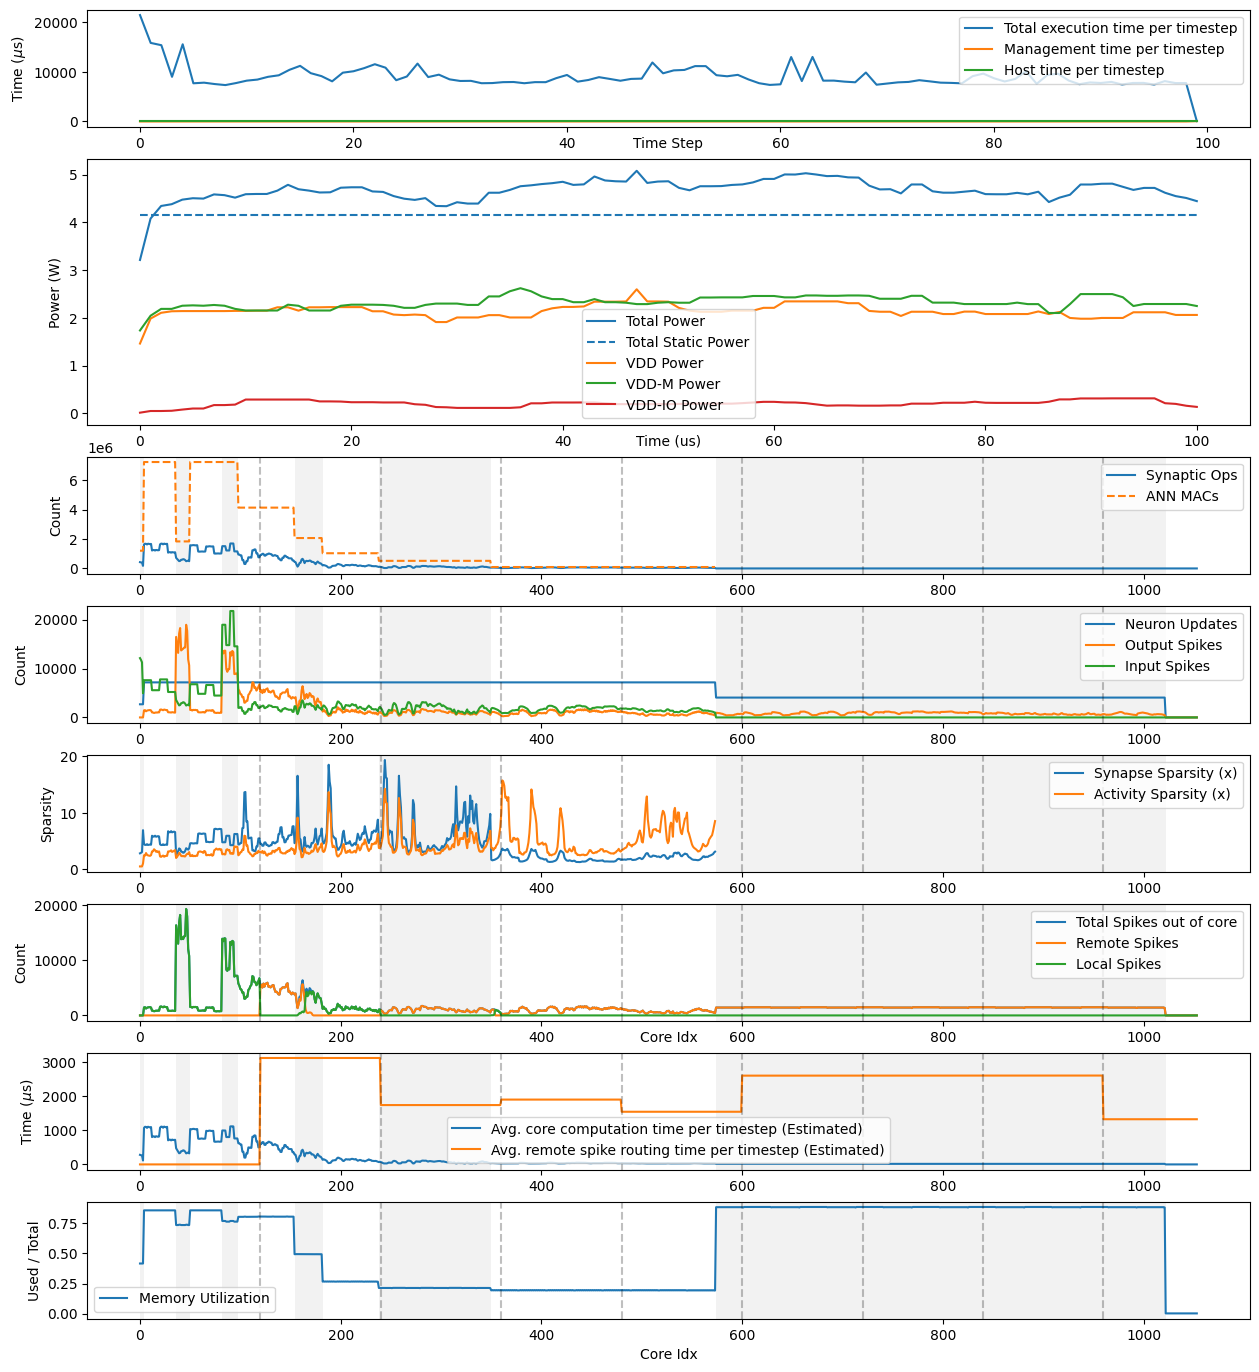

In [32]:
fig = plt.figure(figsize=(15, 17))

layer_start = np.cumsum(num_cores_per_layer) - num_cores_per_layer
layers = [Rectangle((start, -1e10), num, 2e10) for start, num in zip(layer_start[::2], num_cores_per_layer[::2])]
pc = PatchCollection(layers, facecolor='k', alpha=0.05)

gs = gridspec.GridSpec(18, 1)
gs.update(wspace=0.025, hspace=0.75)
ax_time = plt.subplot(gs[0:2, 0])
ax_power = plt.subplot(gs[2:6, 0])
ax_activity_syn = plt.subplot(gs[6:8, 0])
ax_activity = plt.subplot(gs[8:10, 0])
ax_sparsity = plt.subplot(gs[10:12, 0])
ax_spikes = plt.subplot(gs[12:14, 0])
ax_compute = plt.subplot(gs[14:16, 0])
ax_memory = plt.subplot(gs[16:18, 0])
ax_activity_syn.sharex(ax_activity)
ax_activity.sharex(ax_sparsity)
ax_sparsity.sharex(ax_compute)
ax_compute.sharex(ax_memory)

# Runtime Profile
ax_time.plot(runtime_logger.execution_time_per_step, label='Total execution time per timestep')
ax_time.plot(runtime_logger.management_time_per_step, label='Management time per timestep')
ax_time.plot(runtime_logger.host_time_per_step, label='Host time per timestep')
ax_time.set_xlabel('Time Step', labelpad=-10)
ax_time.set_ylabel('Time ($\mu$s)')
ax_time.legend()

# Power Profile
color = next(ax_power._get_lines.prop_cycler)['color']
ax_power.plot(total_power, color=color, label='Total Power')
ax_power.plot(np.zeros_like(total_power)
        + static_total_power,
        linestyle='--', color=color, label='Total Static Power')
color = next(ax_power._get_lines.prop_cycler)['color']
ax_power.plot(vdd_p, color=color, label='VDD Power')
color = next(ax_power._get_lines.prop_cycler)['color']
ax_power.plot(vddm_p, color=color, label='VDD-M Power')
color = next(ax_power._get_lines.prop_cycler)['color']
ax_power.plot(vddio_p, color=color, label='VDD-IO Power')
ax_power.set_ylabel('Power (W)')
ax_power.set_xlabel('Time (us)', labelpad=-10)
ax_power.legend()

# Activity Profile
logical_core_idx = activity_logger.core_idx + 120 * activity_logger.chip_idx
ax_activity_syn.plot(logical_core_idx, activity_logger.syn_ops / num_steps, label='Synaptic Ops')
ax_activity_syn.plot(logical_core_idx[:len(ann_macs)], ann_macs, linestyle='--', label='ANN MACs')
# ax_activity_syn.set_xlabel('Core Idx', labelpad=-10)
ax_activity_syn.set_ylabel('Count')
ax_activity_syn.legend()
ax_activity_syn.add_collection(PatchCollection(layers, facecolor='k', alpha=0.05))

ax_activity.plot(logical_core_idx, activity_logger.dendrite_updates / num_steps, label='Neuron Updates')
ax_activity.plot(logical_core_idx, activity_logger.axon_out / num_steps, label='Output Spikes')
ax_activity.plot(logical_core_idx, activity_logger.spikes_in / num_steps, label='Input Spikes')
# ax_activity.set_xlabel('Core Idx', labelpad=-10)
ax_activity.set_ylabel('Count')
ax_activity.legend()
ax_activity.add_collection(PatchCollection(layers, facecolor='k', alpha=0.05))

ax_sparsity.plot(logical_core_idx[:num_valid], ann_macs * num_steps / activity_logger.syn_ops[:num_valid], label='Synapse Sparsity (x)')
ax_sparsity.plot(logical_core_idx[:num_valid], activity_logger.dendrite_updates[:num_valid] / activity_logger.spike_axon_in[:num_valid] / ucode_passes, label='Activity Sparsity (x)')
# ax_sparsity.set_xlabel('Core Idx', labelpad=-10)
ax_sparsity.set_ylabel('Sparsity')
ax_sparsity.legend()
ax_sparsity.add_collection(PatchCollection(layers, facecolor='k', alpha=0.05))

logical_core_idx = spike_logger.core_idx + 120 * spike_logger.chip_idx
remote_spikes = spike_logger.num_remote_spikes
ax_spikes.plot(logical_core_idx, spike_logger.num_spikes / activity_sparsity, label='Total Spikes out of core')
ax_spikes.plot(logical_core_idx, spike_logger.num_remote_spikes / activity_sparsity, label='Remote Spikes')
ax_spikes.plot(logical_core_idx, spike_logger.num_local_spikes / activity_sparsity, label='Local Spikes')
ax_spikes.set_xlabel('Core Idx', labelpad=-10)
ax_spikes.set_ylabel('Count')
ax_spikes.legend()
ax_spikes.add_collection(PatchCollection(layers, facecolor='k', alpha=0.05))

ax_compute.plot(logical_core_idx, core_computation_time, label='Avg. core computation time per timestep (Estimated)')
# ax_compute.plot(logical_core_idx, time_per_step * np.ones_like(core_computation_time), linestyle='--', label='Avg. time per timestep')
ax_compute.plot(logical_core_idx, remote_spike_routing_time, label='Avg. remote spike routing time per timestep (Estimated)')
# ax_compute.set_xlabel('Core Idx', labelpad=-10)
ax_compute.set_ylabel('Time ($\mu$s)')
ax_compute.legend()
ax_compute.add_collection(PatchCollection(layers, facecolor='k', alpha=0.05))

# Memory Profile
logical_core_idx = memory_logger.core_idx + 120 * memory_logger.chip_idx
ax_memory.plot(logical_core_idx, memory_logger.total_mpds, label='Memory Utilization')
ax_memory.set_ylabel('Used / Total')
ax_memory.set_xlabel('Core Idx')
ax_memory.legend()
ax_memory.add_collection(PatchCollection(layers, facecolor='k', alpha=0.05))

for n in range(np.sum(num_cores_per_layer) // 120):
    ax_activity_syn.axvline(n * 120 + 120, linestyle='--', color='k', alpha=0.25)
    ax_activity.axvline(n * 120 + 120, linestyle='--', color='k', alpha=0.25)
    ax_sparsity.axvline(n * 120 + 120, linestyle='--', color='k', alpha=0.25)
    ax_spikes.axvline(n * 120 + 120, linestyle='--', color='k', alpha=0.25)
    ax_compute.axvline(n * 120 + 120, linestyle='--', color='k', alpha=0.25)
    ax_memory.axvline(n * 120 + 120, linestyle='--', color='k', alpha=0.25)

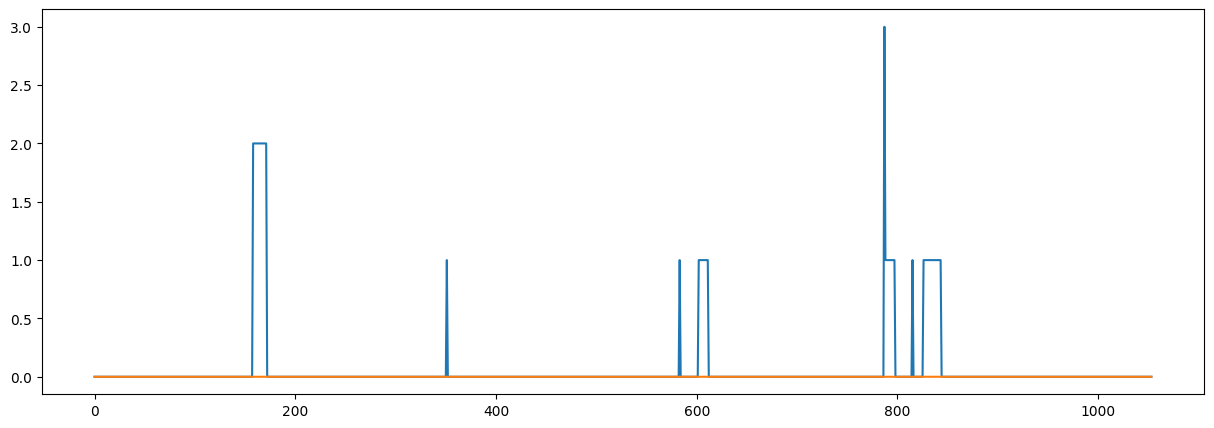

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(logical_core_idx, spike_logger.max_remote_fanout, label='Total Spikes out of core')
ax.plot(logical_core_idx, spike_logger.min_remote_fanout, label='Total Spikes out of core')
ax.plot(logical_core_idx, spike_logger.num_remote_fanout, label='Total Spikes out of core')

In [33]:
from IPython.display import display, clear_output, Markdown
mAP50 = 0.194579
report = f"""
**Video Object Detection on BDD100K Benchmark**
| | YOLO-KP SDNN (Loihi 2, Unthrottled) |
|-|-:|
|mAP@50                           | {mAP50 * 100:.3f}%    |
|Activity Sparsity                | {activity_sparsity_factor:.3f}x     |
|SynOps Sparsity                  | {synops_sparsity_factor:.3f}x     |
|Latency ($\mu$s)                 | {latency:.3f} |
|Inference Throughput (fps)       | {inference_rate:.3f}     |
|Time per timestep ($\mu$s)       | {time_per_step:.3f}  |
|Time per timestep (Est.) ($\mu$s)| {max(time_per_timestep_corebound, np.max(remote_spike_routing_time)):.3f}   |
|Total Power (W)                  | {total_power_mean:.3f}      |
|Dynamic Power (W)                | {dynamic_power_mean:.3f}      |
|Total Energy per Frame (mJ)      | {total_energy * 1e3:.3f}     |
|Dynamic Energy per Frame (mJ)    | {dynamic_energy * 1e3:.3f}      |
|Equivalent TOPS                  | {synops_sparsity_factor * tops:.3f}      |
|Equivalent TOPS/W                | {synops_sparsity_factor * tops_watt:.3f}      |
|Total EDP per Frame ($\mu$J-s)   | {total_energy * latency:.3f}   |
|Dynamic EDP per Frame ($\mu$J-s) | {dynamic_energy * latency:.3f}    |
"""
display(Markdown(report))
print(report)


**Video Object Detection on BDD100K Benchmark**
| | YOLO-KP SDNN (Loihi 2, Unthrottled) |
|-|-:|
|mAP@50                           | 19.458%    |
|Activity Sparsity                | 3.290x     |
|SynOps Sparsity                  | 4.951x     |
|Latency ($\mu$s)                 | 89608.179 |
|Inference Throughput (fps)       | 111.597     |
|Time per timestep ($\mu$s)       | 8960.818  |
|Time per timestep (Est.) ($\mu$s)| 3130.821   |
|Total Power (W)                  | 4.670      |
|Dynamic Power (W)                | 0.514      |
|Total Energy per Frame (mJ)      | 41.843     |
|Dynamic Energy per Frame (mJ)    | 4.605      |
|Equivalent TOPS                  | 0.115      |
|Equivalent TOPS/W                | 0.025      |
|Total EDP per Frame ($\mu$J-s)   | 3749.494   |
|Dynamic EDP per Frame ($\mu$J-s) | 412.667    |



**Video Object Detection on BDD100K Benchmark**
| | YOLO-KP SDNN (Loihi 2, Unthrottled) |
|-|-:|
|mAP@50                           | 19.458%    |
|Activity Sparsity                | 3.290x     |
|SynOps Sparsity                  | 4.951x     |
|Latency ($\mu$s)                 | 89608.179 |
|Inference Throughput (fps)       | 111.597     |
|Time per timestep ($\mu$s)       | 8960.818  |
|Time per timestep (Est.) ($\mu$s)| 3130.821   |
|Total Power (W)                  | 4.670      |
|Dynamic Power (W)                | 0.514      |
|Total Energy per Frame (mJ)      | 41.843     |
|Dynamic Energy per Frame (mJ)    | 4.605      |
|Equivalent TOPS                  | 0.115      |
|Equivalent TOPS/W                | 0.025      |
|Total EDP per Frame ($\mu$J-s)   | 3749.494   |
|Dynamic EDP per Frame ($\mu$J-s) | 412.667    |

